In [16]:
# Dhananjay Tiwari,
# Graduate Student, Mechanical Engineering, Coordinated Science Laboratory, UIUC
# Created on : July 17, 2023
# This file implements clustering algorithm with inequality constraints

In [17]:
# import modules
import numpy as np # Computational python programming and not include this? Can't happen!
import matplotlib.pyplot as plt # module to make plots

In [18]:
# create FLP class and its associated functions
class FLP():

    # declare the class variables
    N : int # number of resources
    M : int # number of facilities
    resLoc : np.ndarray # resource locations
    facLoc : np.ndarray # facility locations (initial)
    P : np.ndarray # association matrix between resources and facilities (P-probabilities)
    Phi : np.ndarray # probability array for inequality constraints getting satisfied (Phi-probabilities)

    # initialize the class variables
    def __init__(self, N, M, resLoc, facLoc):
        self.N = N
        self.M = M
        self.resLoc = resLoc
        self.facLoc = facLoc
        self.P = np.ones([N, M])
        self.P = self.P / np.sum(self.P, axis = 1, keepdims=True) # normalize the P-probabilities
        self.Phi = np.ones([M, 1])*1e-5 # start with a small Phi-probabilities

        print('================= Class FLP() initialized =================')

    # compute the association cost matrix between the resources and the facilities
    def association_cost_matrix(self):
        ''' 
        input: self, the class instance
        output: association cost matrix of size N x M
        '''
        # initialize the association cost matrix
        D = np.zeros([self.N, self.M])

        X = self.resLoc, Y = self.facLoc # access resource and facility locations
        tileX = np.kron(np.ones([1,self.M]), X)
        flatY = np.reshape(Y, [1,2*self.M])
        diff = tileX - flatY
        split = np.split_array(diff, self.M)
        D = np.linalg.norm(split, axis = self.M-1)

        return D
    
    # compute the set of all inequality constraint functions
    def ineq_cons(self, facLoc):
        '''
        input - self: the class instance
                func_ineq: an array of inequality constraint functions
        output - vec_ineq: a vector of inequality constraints of the form - vec_ineq <= 0
        '''
        # initialize the inequality constraint vectors
        num_ineq = self.M
        vec_ineq = np.zeros([num_ineq, 1])
        # circular inequality constraint
        center = np.array([[10, 10], [10,10], [20,20], [30,30]])
        radius = np.array([[1],[1],[1],[1]])
        vec_ineq = radius - np.linalg.norm(facLoc - center, axis = 1, keepdims=True)
        return vec_ineq
    
    # compute the probability associations using gibbs distribution
    def gibbs_associations(self, beta, gamma, Lambda, xi, R):
        ''' 
        input - self: the class instance
        output - Phi: Phi-probabilities
                 P: P-probabilities
        '''
        # first compute Phi-probabiltiies
        exp_term = np.exp(np.max(100, -gamma * np.multiply(Lambda, np.tanh(xi*self.ineq_cons(self.facLoc)))))
        Phi = exp_term / (1 + exp_term)
        # then compute P-probabilities
        D = self.association_cost_matrix()
        Lambda_tile = np.kron(np.ones([1, self.M]), Lambda)
        Phi_tile = np.kron(np.ones([1, self.M]), Phi)
        sech_term = np.kron(np.ones([1, self.M]), 1/np.cosh(xi*self.ineq_cons(self.facLoc))**2)
        num = np.exp(-beta * (D + xi*np.multiply(Lambda_tile, np.multiply(Phi_tile, np.multiply(R, sech_term)))))
        den = np.kron(np.ones([1, self.M]), np.sum(num, axis = 1))
        P = num/den
        return Phi, P


In [19]:
# define functions to assist the implementation

def testcases(tc_name):
    ''' 
    input - tc_name: name of the testcase
    output - N: number of resources
             M: number of facilities
             resLoc: resource locations
             facLoc: facility locations (initial)
    '''
    if 'small_tc_40_4' == tc_name :
        d = 2 # dimension of the coordinates
        N = 40 # number of resources
        M = 4 # number of facilties
        mean = [np.array([0,0]), np.array([3,4]), np.array([-4,-3]), np.array([-5,5])] # cluster means
        cov = [np.array([[2, 0],[0, 3]]),
               np.array([[5, 4],[4, 5]]),
               np.array([[6, 3],[3, 3]]),
               np.array([[4, 2],[2, 6]])] # cluster covariances
        split = [12, 8, 9, 11] # no of points in every cluster
        resLoc = np.zeros([N, d]) # initialize resource locations
        facLoc = np.zeros([M, d]) # intiialize facility locations
        # generate resource and facility locations using normal distribution
        cnt = 0
        for i in range(len(mean)):
            resLoc[cnt:cnt+split[i], :] = np.random.multivariate_normal(mean[i], cov[i], split[i])
            cnt = cnt + split[i]

    return N, M, resLoc, facLoc

 ================ Small Testcase 1 ================ 


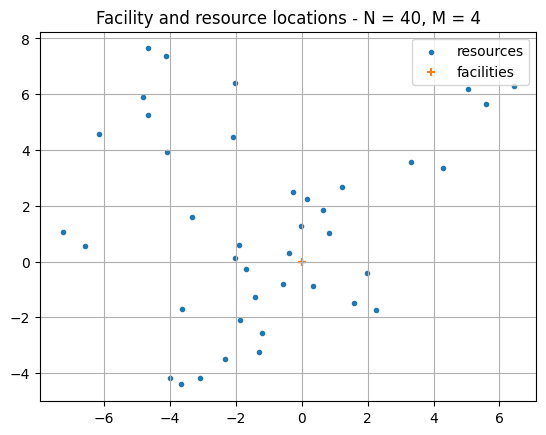

================= Class FLP() initialized =================


TypeError: only integer scalar arrays can be converted to a scalar index

In [20]:
# implement the FLP algorithm on a 2D example problem
print(' ================ Small Testcase 1 ================ ')
N, M, resLoc, facLoc = testcases('small_tc_40_4')
plt.scatter(resLoc[:, 0], resLoc[:, 1], marker = ".")
plt.scatter(facLoc[:, 0], facLoc[:, 1], marker = "+")
plt.title('Facility and resource locations - N = ' + str(N) + ', M = ' + str(M))
plt.legend(['resources', 'facilities'])
plt.grid()
plt.show()

# initialize the FLP class
flp = FLP(N, M, resLoc, facLoc)
# print('initial P-probabilities = \n', flp.P)
# print('initial Phi-probabilities = \n', flp.Phi)

# Initialize the annealing parameters/constants/weights
rho = np.ones([N, 1]) # resource weights
beta = 1e-8 # entropy term annealing parameter
gamma = 100 # inequality term annealing parameter
Lambda = np.ones([M, 1])*1
xi = 100

Phi, P = flp.gibbs_associations(beta, gamma, Lambda, xi, R = np.zeros([N, M]))
print(Phi)
# print(P)

while beta < 100:
    # flp.Phi, flp.P = flp.gibbs_associations(gamma, Lambda, xi)
#     optimize free energy w.r.t. facility locations
#     update facility locations
    beta = 10*beta

In [173]:
# test block for functions

def apply_function(func, x):
   return func[0](x), func[1](x)
def square1(x):
   return x ** 2
def sum(x):
   return x + x
result = apply_function(np.array([square1, sum]), 3)

inf


/var/folders/sh/ndxykdmj1q9cwr2kpvkvcbs80000gn/T/ipykernel_2529/2494013014.py:11: RuntimeWarning: overflow encountered in exp
  print(np.exp(999))
